Raw shapes (as read from FITS):
  Band 3: (1, 1, 3456, 3456)
  Band 6: (1, 1, 1250, 1250)
After squeeze:
  Band 3: (3456, 3456) ndim = 2
  Band 6: (1250, 1250) ndim = 2

Detected 2D images -> using celestial WCS for reprojection.
Target shape_out: (1250, 1250)

Reprojecting Band 3 to Band 6 WCS ...
Reprojection successful. Saving reprojected file...
Saved reprojected Band 3 to: band3_reprojected_to_band6.fits
Plotting shapes (2D arrays):
  Band6: (1250, 1250)
  Band3(reprojected): (1250, 1250)

RMS (sigma-clip) Band3: 2.80847e-04, Band6: 1.66243e-04

Peaks (pixel coords):
  Band6 peak (x,y): 625 623
  Band3 peak (x,y): 627 620


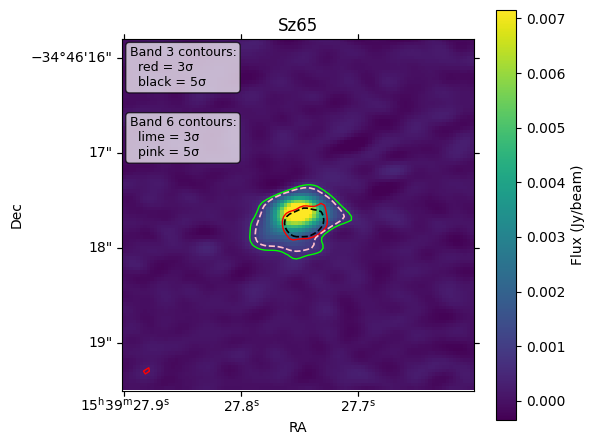

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import simple_norm
from astropy.stats import sigma_clip
from reproject import reproject_interp
import warnings
from astropy.wcs import FITSFixedWarning

# Ignore WCS warnings
warnings.simplefilter('ignore', category=FITSFixedWarning)

band3_path = r"C:/Users/maitr/OneDrive/Documents/Solar research/Dust in wind/member.uid___A001_X2d1f_X5b6.sz65_sz66_sci.spw5_7_9_11.cont.I.tt1.pbcor.fits"
band6_path = r"C:/Users/maitr/OneDrive/Documents/Solar research/Dust in wind/member.uid___A001_X12a3_X407.Sz65_sci.spw23_25_27_29_31_33_35_37_39_41.cont.I.pbcor.fits"

# ---------------------------
# function for sigma-clip method - rms noise
# ---------------------------
def compute_rms_sigma_clip(data, sigma=3):
    flat = data.flatten()
    flat = flat[~np.isnan(flat)]
    clipped = sigma_clip(flat, sigma=sigma, maxiters=5, cenfunc='median', stdfunc='std')
    return np.std(clipped.data[~clipped.mask])

# ---------------------------
# Load FITS files 
# ---------------------------
hdul3 = fits.open(band3_path)
hdul6 = fits.open(band6_path)

hdu3 = hdul3[0]
hdu6 = hdul6[0]

data3_orig = hdu3.data
data6_orig = hdu6.data
hdr3_orig = hdu3.header
hdr6_orig = hdu6.header

print("Raw shapes (as read from FITS):")
print("  Band 3:", getattr(data3_orig, "shape", None))
print("  Band 6:", getattr(data6_orig, "shape", None))

# Squeeze to remove single-dimensional axes if present
data3 = np.squeeze(data3_orig)
data6 = np.squeeze(data6_orig)

print("After squeeze:")
print("  Band 3:", data3.shape, "ndim =", data3.ndim)
print("  Band 6:", data6.shape, "ndim =", data6.ndim)

# ---------------------------
# WCS setup and reprojection 
# ---------------------------

print("\nDetected 2D images -> using celestial WCS for reprojection.")

# Create celestial WCS for 2D reprojection
wcs3 = WCS(hdr3_orig).celestial
wcs6 = WCS(hdr6_orig).celestial

# Match Band 3 to Band 6 grid
shape_out = data6.shape  # (ny, nx)
print("Target shape_out:", shape_out)

# ---------------------------
# Perform Reproject Band 3 -> Band 6
# ---------------------------

print("\nReprojecting Band 3 to Band 6 WCS ...")
reproj3, footprint = reproject_interp((data3, wcs3), wcs6, shape_out=shape_out)
print("Reprojection successful. Saving reprojected file...")

# Save reprojected Band 3
out_path = "band3_reprojected_to_band6.fits"
fits.PrimaryHDU(data=reproj3, header=hdr6_orig).writeto(out_path, overwrite=True)
print("Saved reprojected Band 3 to:", out_path)

# Replace with reprojected data for further analysis/plotting
data3 = reproj3
hdr3 = hdr6_orig
wcs3 = wcs6  # they now share the same WCS
wcs6 = wcs6

# ---------------------------
# Prepare 2D data for plotting
# ---------------------------
data6_2d = data6
data3_2d = data3

print("Plotting shapes (2D arrays):")
print("  Band6:", data6_2d.shape)
print("  Band3(reprojected):", data3_2d.shape)

# ---------------------------
# Compute RMS (sigma-clip) noise
# ---------------------------
rms_band3 = compute_rms_sigma_clip(data3_2d, sigma=3)
rms_band6 = compute_rms_sigma_clip(data6_2d, sigma=3)

print(f"\nRMS (sigma-clip) Band3: {rms_band3:.5e}, Band6: {rms_band6:.5e}")

# ---------------------------
# Find peaks (for zoom region)
# ---------------------------
peak_b6 = np.unravel_index(np.nanargmax(data6_2d), data6_2d.shape)
x_b6_peak, y_b6_peak = peak_b6[1], peak_b6[0]

peak_b3 = np.unravel_index(np.nanargmax(data3_2d), data3_2d.shape)
x_b3_peak, y_b3_peak = peak_b3[1], peak_b3[0]

print("\nPeaks (pixel coords):")
print("  Band6 peak (x,y):", x_b6_peak, y_b6_peak)
print("  Band3 peak (x,y):", x_b3_peak, y_b3_peak)

# ---------------------------
# Define zoom region using Band6 peak and ensure bounds
# ---------------------------
box_size = 50
x_min = max(x_b6_peak - box_size, 0)
x_max = min(x_b6_peak + box_size, data6_2d.shape[1])
y_min = max(y_b6_peak - box_size, 0)
y_max = min(y_b6_peak + box_size, data6_2d.shape[0])

zoom_band6 = data6_2d[y_min:y_max, x_min:x_max]
zoom_band3 = data3_2d[y_min:y_max, x_min:x_max]

# Create zoom WCS by slicing the celestial WCS
# Use celestial WCS for plotting (2D)
zoom_wcs = wcs6.celestial.slice((slice(y_min, y_max), slice(x_min, x_max)))

# ---------------------------
# Plot aligned images with contours
# ---------------------------
plt.figure(figsize=(6, 5))
ax = plt.subplot(projection=zoom_wcs)

norm = simple_norm(zoom_band6, 'linear', percent=99.5)
im = ax.imshow(zoom_band6, origin='lower', cmap='viridis', norm=norm)

# When WCS of both images match, we can use the same transform
transform = ax.get_transform(zoom_wcs)

# Band 3 contours (reprojected)
ax.contour(zoom_band3, levels=[3 * rms_band3], colors='red', linewidths=1.0, linestyles='solid', transform=transform)
ax.contour(zoom_band3, levels=[5 * rms_band3], colors='black', linewidths=1.2, linestyles='dashed', transform=transform)

# Band 6 contours
ax.contour(zoom_band6, levels=[3 * rms_band6], colors='lime', linewidths=1.0, linestyles='solid', transform=transform)
ax.contour(zoom_band6, levels=[5 * rms_band6], colors='pink', linewidths=1.2, linestyles='dashed', transform=transform)

plt.xlabel('RA')
plt.ylabel('Dec')
plt.title("Sz65")
plt.colorbar(im, ax=ax, label='Flux (Jy/beam)')

#  text
text_props = dict(boxstyle='round', facecolor='white', alpha=0.7)
ax.text(0.02, 0.98, f"Band 3 contours:\n  red = 3σ \n  black = 5σ", transform=ax.transAxes, fontsize=9, verticalalignment='top', color='black', bbox=text_props)
ax.text(0.02, 0.78, f"Band 6 contours:\n  lime = 3σ \n  pink = 5σ", transform=ax.transAxes, fontsize=9, verticalalignment='top', color='black', bbox=text_props)

plt.tight_layout()
plt.show()

In [3]:
# ---------------------------
# Compute RMS (sigma-clip) noise in mJy/beam
# ---------------------------
rms_band3 = compute_rms_sigma_clip(data3_2d, sigma=3) * 1e3  # Jy → mJy
rms_band6 = compute_rms_sigma_clip(data6_2d, sigma=3) * 1e3  # Jy → mJy

print(f"\nRMS (sigma-clip) Band3: {rms_band3:.3f} mJy/beam, Band6: {rms_band6:.3f} mJy/beam")

# ---------------------------
# Compute integrated flux (Jy)
# ---------------------------
flux_band3 = np.nansum(data3_2d)
flux_band6 = np.nansum(data6_2d)

print(f"\nTotal Flux Density:")
print(f"  Band3: {flux_band3:.3e} Jy")
print(f"  Band6: {flux_band6:.3e} Jy")

# ---------------------------
# Compute spectral index α_mm between Band3 (100 GHz) and Band6 (230 GHz)
# α = log(S2/S1) / log(ν2/ν1)
# ---------------------------
nu_band3 = 100e9   # Hz
nu_band6 = 230e9   # Hz
alpha_mm = np.log(flux_band6 / flux_band3) / np.log(nu_band6 / nu_band3)

print(f"\nSpectral index α_mm = {alpha_mm:.3f}")



RMS (sigma-clip) Band3: 0.281 mJy/beam, Band6: 0.166 mJy/beam

Total Flux Density:
  Band3: 1.277e-01 Jy
  Band6: 7.993e-01 Jy

Spectral index α_mm = 2.202


In [2]:
#Check WCS alignment numerically

ra6, dec6 = wcs6.wcs_pix2world(x_b6_peak, y_b6_peak, 0)
ra3, dec3 = wcs3.wcs_pix2world(x_b3_peak, y_b3_peak, 0)
print(f"Band6 peak world coords: RA={ra6}, Dec={dec6}")
print(f"Band3 peak world coords: RA={ra3}, Dec={dec3}")
print(f"Offset in arcsec: {3600*(ra3 - ra6):.3f}″, {3600*(dec3 - dec6):.3f}″")


Band6 peak world coords: RA=234.865625, Dec=-34.77156499999556
Band3 peak world coords: RA=234.865599975951, Dec=-34.771595833326316
Offset in arcsec: -0.090″, -0.111″
